### Importing the libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving news.csv to news.csv


### Loading data

In [32]:
df = pd.read_csv("news.csv")

### Data exploration

In [33]:
df.shape # checking for total no. of articles

(6335, 4)

In [34]:
df.head() # checking for order

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [35]:
df.isnull().sum() # Checking for null entries

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [36]:
import string # function defined to clean dataset
def clean_text(text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    words = words.replace('—','')
    return words

df['text'] = df['text'].apply(clean_text)
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,daniel greenfield a shillman journalism f...,FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,us secretary of state john f kerry said...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 ...,FAKE
4,875,The Battle of New York: Why This Primary Matters,its primary day in new york and frontru...,REAL


### Splitting the dataset

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
train, test = train_test_split(df, test_size = 0.07)
train, validation = train_test_split(train, test_size = 0.03) # split into training, validation and test sets 

In [39]:
train.head()

,Unnamed: 0,title,text,label
4276,2159,Senate Democrats block swift passage of Keysto...,senate supporters of the keystone xl pip...,REAL
3144,8845,Halloween Costumes Mocking #NoDAPL Activists H...,those who follow news shared by alternat...,FAKE
1138,9615,Tradesman keeps promise,october 27 2016 ivy pollard 73 from the...,FAKE
4674,1514,Hillary Clinton campaign trolls GOP by boostin...,donald trump continues to rage against h...,REAL
5917,1076,Hillary Clinton had an amazing night — and not...,tuesday night was an amazing night for ...,REAL


### Preparing the data

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>" 
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.text) # only text feature is used for training
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(np.array(train.text))
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type)

max_length = len(training_padded[0])

validation_sequences = tokenizer.texts_to_sequences(np.array(validation.text))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [42]:
# setting the training inputs
train_x = np.copy(training_padded)
validate_x = np.copy(validation_padded)

In [43]:
# setting the training targets
train_y = train['label'].replace('FAKE',1).replace('REAL',0).values
validate_y = validation['label'].replace('FAKE',1).replace('REAL',0).values

### Defining the model

In [44]:
import tensorflow as tf

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

### Training the model

In [46]:
history = model.fit(train_x, train_y, verbose = 2, epochs = 10, validation_data = (validate_x, validate_y),
                   callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6)])

Epoch 1/10
179/179 - 10s - loss: 0.6198 - accuracy: 0.7459 - val_loss: 0.4500 - val_accuracy: 0.8531
Epoch 2/10
179/179 - 9s - loss: 0.3512 - accuracy: 0.8847 - val_loss: 0.2810 - val_accuracy: 0.8701
Epoch 3/10
179/179 - 9s - loss: 0.2051 - accuracy: 0.9330 - val_loss: 0.2294 - val_accuracy: 0.8983
Epoch 4/10
179/179 - 9s - loss: 0.1260 - accuracy: 0.9664 - val_loss: 0.2000 - val_accuracy: 0.9209
Epoch 5/10
179/179 - 9s - loss: 0.0782 - accuracy: 0.9834 - val_loss: 0.1874 - val_accuracy: 0.9266
Epoch 6/10
179/179 - 9s - loss: 0.0489 - accuracy: 0.9933 - val_loss: 0.1795 - val_accuracy: 0.9379
Epoch 7/10
179/179 - 9s - loss: 0.0300 - accuracy: 0.9977 - val_loss: 0.1720 - val_accuracy: 0.9435
Epoch 8/10
179/179 - 9s - loss: 0.0188 - accuracy: 0.9989 - val_loss: 0.1611 - val_accuracy: 0.9435
Epoch 9/10
179/179 - 9s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.1605 - val_accuracy: 0.9492
Epoch 10/10
179/179 - 9s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1612 - val_accuracy: 0.943

### Predicting using test data

In [47]:
test_sequences = tokenizer.texts_to_sequences(np.array(test.text))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [48]:
preds = np.round(model.predict(test_padded))

In [49]:
acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["label"].replace('FAKE',1).replace('REAL',0).values)) / len(test)
print("Accuracy of the mode is: ", acc )

Accuracy of the mode is:  0.9436936936936937


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


### Confusion Matrix

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
TN, FP, FN, TP = confusion_matrix(test["label"].replace('FAKE',1).replace('REAL',0).values, preds).ravel()
cm = confusion_matrix(test["label"].replace('FAKE',1).replace('REAL',0).values, preds)

(0.0, 1.0, 0.0, 1.0)

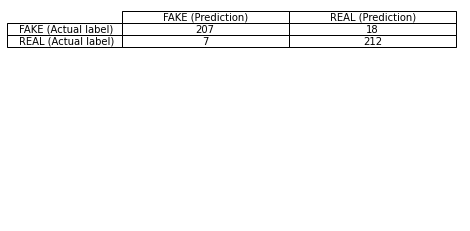

In [53]:
plt.table(cellText=[[TP,FN],[FP,TN]],cellLoc='center',colWidths=[0.5,0.5],rowLabels=['FAKE (Actual label)','REAL (Actual label)'],colLabels=['FAKE (Prediction)','REAL (Prediction)'],loc=0)
plt.axis('off')